In [1]:
from src.DeepRock.models import AdvSeg
from src.DeepRock.data import DataGenerator
from src.DeepRock.utils import split_trn_vld_tst, test_fn, plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn import metrics

Using TensorFlow backend.


In [90]:
cls_names = ['Vegetation', 'Unkown Rocks', 'Carbonate_sediment',
           'Dolerite', 'Feldspathic_sediment', 'Felsic_volcanic', 'Gneiss', 'Granite', 'Mafic_volcanic', 'Quartz_sediment']

In [2]:
dtype = 'sent_ast_geo'

#### start to build Conv2D for different input data

In [3]:
conv = AdvSeg(dtype=dtype)
# sa_conv = AdvSeg(dtype=sa_dtype)
# sag_conv = AdvSeg(dtype=sag_dtype)
conv.build_SegmentationNet()
# sa_conv.build_SegmentationNet()
# sag_conv.build_SegmentationNet()

building Segmentation U-net ...
[64, 64, 64, 64]
[64, 64, 64]
compiling Segmentation only, lr is 0.001 ...


##### plot the ground truth

In [24]:
# convert the ground truth into a big block
block_id = 3
ids = sorted(glob.glob('./data/block{0}/test/Y/*.npy'.format(block_id)), key=lambda f: int(''.join(filter(str.isdigit, f))))
count = 0
track = []
for i in range(5):
    tmp1 = []
    for j in range(5):
        tmp1.append(np.argmax(np.load(ids[count]), axis=0))
        count += 1
    track.append(np.concatenate(tmp1, axis=1))
out = np.concatenate(track, axis=0)
np.save('./data/block{0}/Y.npy'.format(block_id), out)

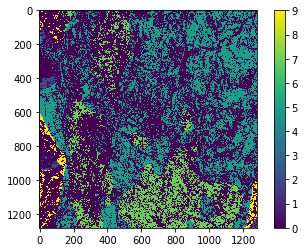

In [49]:
plt.imshow(out)
plt.colorbar()

##### load weights and predicts

In [16]:
conv.load_weights('./Segmentation/sent_ast_geo/weights-151-0.66.hdf5')

#### test on block3

In [50]:
X_id = sorted(glob.glob('./data/block{0}/test/X/*.npy'.format(block_id)), key=lambda f: int(''.join(filter(str.isdigit, f))))
X = [np.transpose(np.load(file), [1,2,0]) for file in X_id]
preds = conv.predict(np.stack(X))

In [18]:
count = 0
track = []
for i in range(5):
    tmp1 = []
    for j in range(5):
        tmp1.append(np.argmax(preds[count,:,:,:], axis=2))
        count += 1
    track.append(np.concatenate(tmp1, axis=1))
p = np.concatenate(track, axis=0)
np.save('./data/block{0}/preds_{1}.npy'.format(block_id, dtype), p)

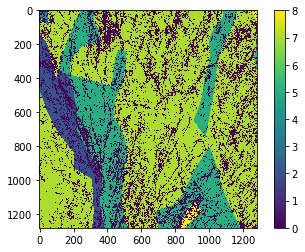

In [97]:
Y = np.load('./data/block2/Y.npy')
plt.imshow(Y)
plt.colorbar()

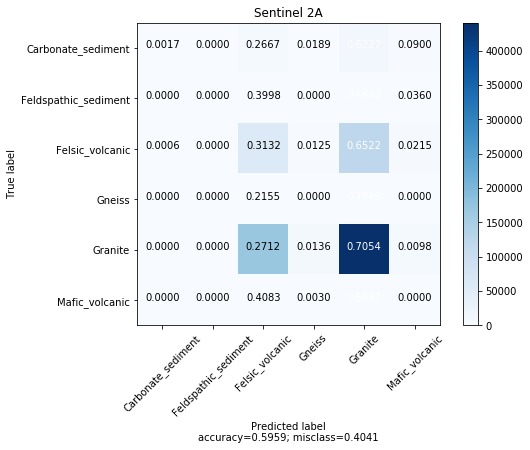

In [98]:
p1 = np.load('./data/block2/preds_sent.npy')
cm = metrics.confusion_matrix(Y.flatten(), p1.flatten(), labels=np.unique(Y)[1:])
plot_confusion_matrix(cm, target_names=[cls_names[i] for i in np.unique(Y)[1:]], 
                      normalize=True, title='Sentinel 2A')

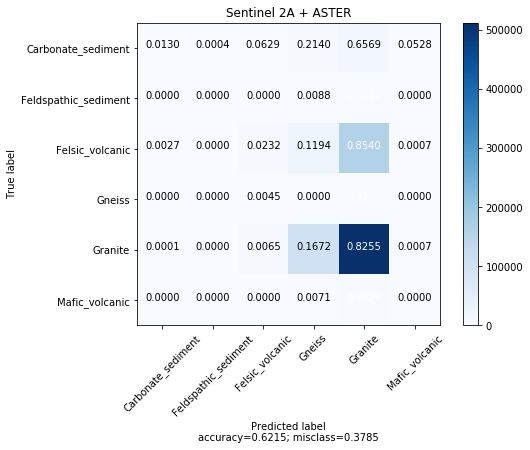

In [99]:
p2 = np.load('./data/block2/preds_sent_ast.npy')
cm = metrics.confusion_matrix(Y.flatten(), p2.flatten(), labels=np.unique(Y)[1:])
plot_confusion_matrix(cm, target_names=[cls_names[i] for i in np.unique(Y)[1:]], 
                      normalize=True, title='Sentinel 2A + ASTER')

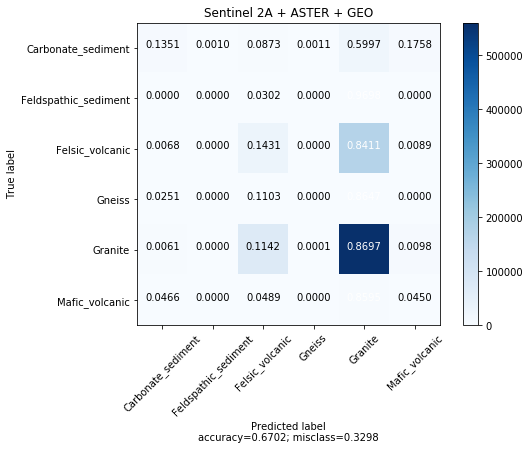

In [100]:
p3 = np.load('./data/block2/preds_sent_ast_geo.npy')
cm = metrics.confusion_matrix(Y.flatten(), p3.flatten(), labels=np.unique(Y)[1:])
plot_confusion_matrix(cm, target_names=[cls_names[i] for i in np.unique(Y)[1:]], 
                      normalize=True, title='Sentinel 2A + ASTER + GEO')

#### test on all 3 blocks

In [156]:
Y = np.concatenate([np.load('./data/block1/Y.npy').flatten(), 
                    np.load('./data/block2/Y.npy').flatten(), 
                    np.load('./data/block3/Y.npy').flatten()])

In [157]:
p1 = np.concatenate([np.load('./data/block1/preds_sent.npy').flatten(),
                     np.load('./data/block2/preds_sent.npy').flatten(),
                     np.load('./data/block3/preds_sent.npy').flatten()])
p2 = np.concatenate([np.load('./data/block1/preds_sent_ast.npy').flatten(),
                     np.load('./data/block2/preds_sent_ast.npy').flatten(),
                     np.load('./data/block3/preds_sent_ast.npy').flatten()])
p3 = np.concatenate([np.load('./data/block1/preds_sent_ast_geo.npy').flatten(),
                     np.load('./data/block2/preds_sent_ast_geo.npy').flatten(),
                     np.load('./data/block3/preds_sent_ast_geo.npy').flatten()])

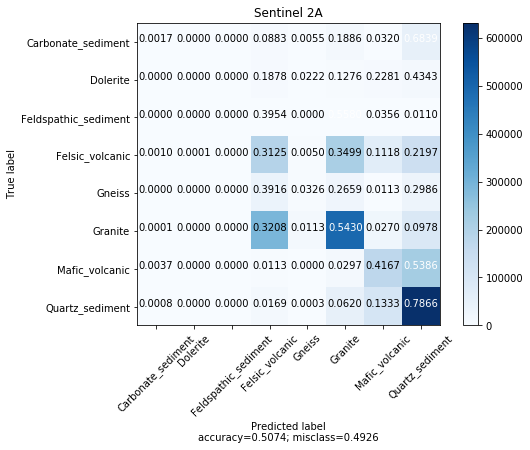

In [136]:
cm = metrics.confusion_matrix(Y, p1, labels=np.unique(Y)[1:])
plot_confusion_matrix(cm, target_names=[cls_names[i] for i in np.unique(Y)[1:]], 
                      normalize=True, title='Sentinel 2A')

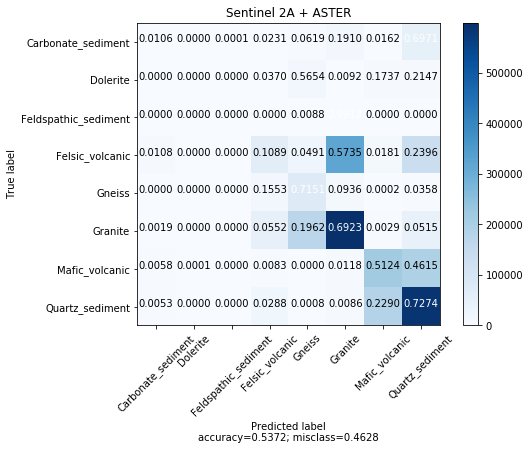

In [137]:
cm = metrics.confusion_matrix(Y, p2, labels=np.unique(Y)[1:])
plot_confusion_matrix(cm, target_names=[cls_names[i] for i in np.unique(Y)[1:]], 
                      normalize=True, title='Sentinel 2A + ASTER')

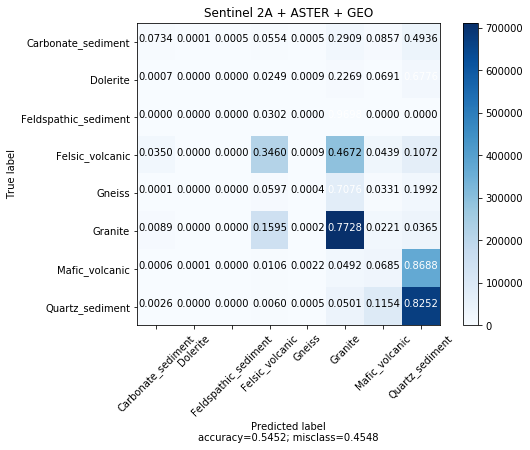

In [138]:
cm = metrics.confusion_matrix(Y, p3, labels=np.unique(Y)[1:])
plot_confusion_matrix(cm, target_names=[cls_names[i] for i in np.unique(Y)[1:]], 
                      normalize=True, title='Sentinel 2A + ASTER + GEO')

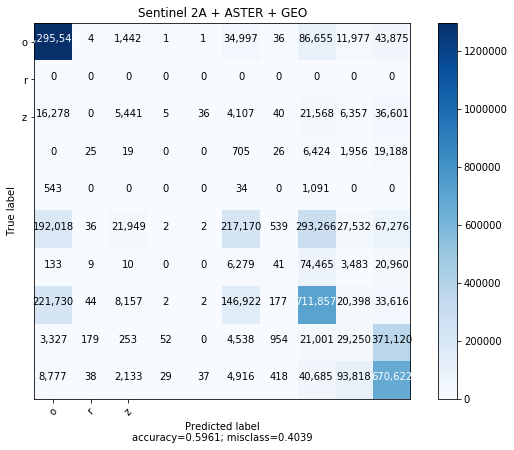

In [176]:
cm = metrics.confusion_matrix(Y, p3, labels=np.arange(10))
plot_confusion_matrix(cm, target_names='orz', 
                      normalize=False, title='Sentinel 2A + ASTER + GEO')

In [172]:
metrics.precision_recall_fscore_support(Y, p1)

/Users/chenyz/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/chenyz/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(array([ 0.73359997,  0.        ,  0.04091653,  0.        ,  0.        ,
         0.32387053,  0.1678677 ,  0.57325543,  0.44616745,  0.53162557]),
 array([ 0.92757983,  0.        ,  0.00138224,  0.        ,  0.        ,
         0.23220947,  0.03072689,  0.43309461,  0.40304499,  0.76874225]),
 array([ 0.81926416,  0.        ,  0.00267414,  0.        ,  0.        ,
         0.27048555,  0.05194555,  0.49341447,  0.42351136,  0.62856529]),
 array([1474534,       0,   90433,   28343,    1668,  819790,  105380,
        1142905,  430674,  821473]))

#### test on block1 with 64X64 tile size

In [114]:
_, _, _, _, X_tst, Y_tst = split_trn_vld_tst('./data/block1_64/', vld_rate=0.2, tst_rate=0.1, seed=10)

split into 3959 train, 1131 validation, 565 test samples


In [115]:
from src.DeepRock.utils import get_XY

In [116]:
X_s, Y_s = get_XY(X_tst, Y_tst, 'sent')
X_sa, Y_sa = get_XY(X_tst, Y_tst, 'sent_ast')
X_sag, Y_sag = get_XY(X_tst, Y_tst, 'sent_ast_geo')

In [118]:
s_conv = AdvSeg(dtype='sent', dim_width=64, dim_height=64)
sa_conv = AdvSeg(dtype='sent_ast', dim_width=64, dim_height=64)
sag_conv = AdvSeg(dtype='sent_ast_geo', dim_width=64, dim_height=64)
s_conv.build_SegmentationNet(n_ch_list=[64, 64])
sa_conv.build_SegmentationNet(n_ch_list=[64, 64])
sag_conv.build_SegmentationNet(n_ch_list=[64, 64])

building Segmentation U-net ...
[64, 64]
[64]
compiling Segmentation only, lr is 0.001 ...
building Segmentation U-net ...
[64, 64]
[64]
compiling Segmentation only, lr is 0.001 ...
building Segmentation U-net ...
[64, 64]
[64]
compiling Segmentation only, lr is 0.001 ...


In [120]:
s_conv.load_weights('./Segmentation/Segmentation/sent/weights-99-0.68.hdf5')
sa_conv.load_weights('./Segmentation/Segmentation/sent_ast/weights-94-0.69.hdf5')
sag_conv.load_weights('./Segmentation/Segmentation/sent_ast_geo/weights-87-0.49.hdf5')

In [121]:
p_s = s_conv.predict(X_s)
p_sa = sa_conv.predict(X_sa)
p_sag = sag_conv.predict(X_sag)

In [125]:
Y = np.argmax(Y_s, axis=3).flatten()
p1 = np.argmax(p_s, axis=3).flatten()
p2 = np.argmax(p_sa, axis=3).flatten()
p3 = np.argmax(p_sag, axis=3).flatten()

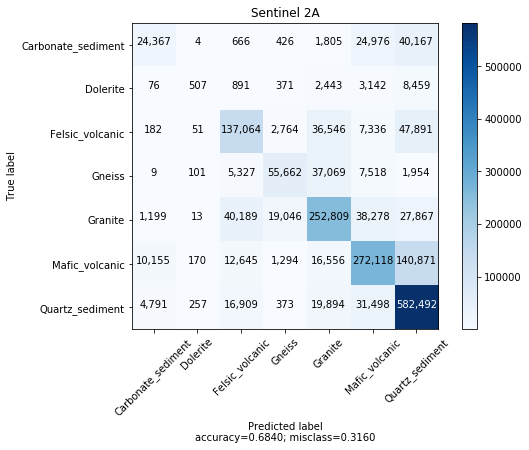

In [131]:
cm = metrics.confusion_matrix(Y, p1, labels=np.unique(Y)[2:])
plot_confusion_matrix(cm, target_names=[cls_names[i] for i in np.unique(Y)[2:]], 
                      normalize=False, title='Sentinel 2A')

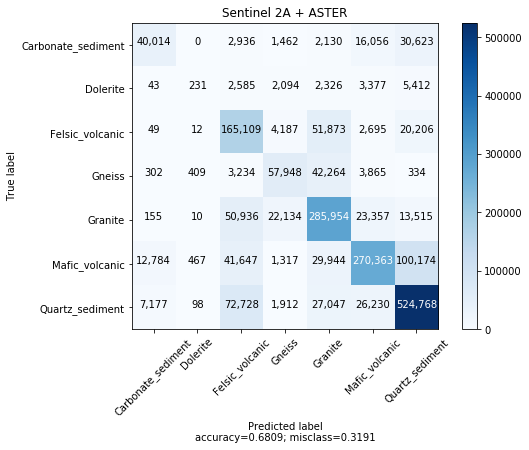

In [132]:
cm = metrics.confusion_matrix(Y, p2, labels=np.unique(Y)[2:])
plot_confusion_matrix(cm, target_names=[cls_names[i] for i in np.unique(Y)[2:]], 
                      normalize=False, title='Sentinel 2A + ASTER')

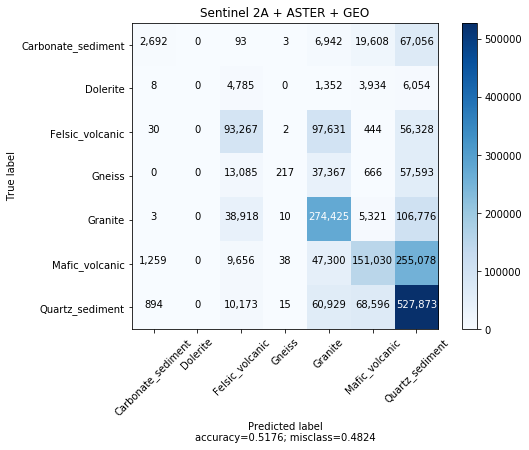

In [133]:
cm = metrics.confusion_matrix(Y, p3, labels=np.unique(Y)[2:])
plot_confusion_matrix(cm, target_names=[cls_names[i] for i in np.unique(Y)[2:]], 
                      normalize=False, title='Sentinel 2A + ASTER + GEO')

#### calculate the accuracy

In [161]:
def acc_cls(ppreds, yy):
    preds = np.copy(ppreds)
    y = np.copy(yy)
    acc_cls = []
    for cls in range(10):
        preds[np.where(preds != cls)] = -1
        y[np.where(y != cls)] = -1
        acc_cls.append(np.where(preds == y)[0].shape[0]/y.shape[0])
    return acc_cls

In [164]:
acc_cls_s = acc_cls(p2, Y)

In [165]:
acc_cls_s

[0.8602716064453125, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [166]:
np.unique(p1)

array([0, 1, 2, 3, 5, 6, 7, 8, 9])

In [171]:
np.where(p3 == Y)[0].shape[0] / Y.shape[0]

0.5960951741536459

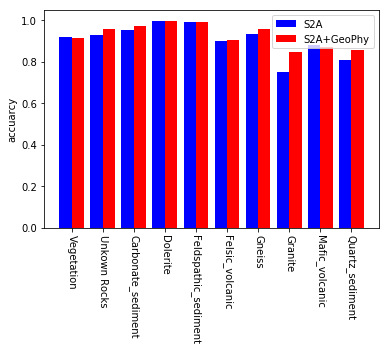

In [126]:
ax = plt.subplot(111)
ax.bar(np.arange(10)-0.2, acc_cls_s, width=0.4, color='b', align='center', label='S2A')
ax.bar(np.arange(10)+0.2, acc_cls_sg, width=0.4, color='r', align='center', label='S2A+GeoPhy')
plt.xticks(np.arange(10), cls_names, rotation=270)
plt.ylabel('accuarcy')
plt.legend()